In [3]:
from __future__ import division
from collections import defaultdict
from time import time
import numpy as np
np.random.seed(1337)
from scipy.stats import poisson, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.datasets import load_digits

In [4]:
alpha = 6
sigma_x = sigma = 5
sigma_a = 5

In [31]:
def log_X_given_Z(X, Z):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    I1 = np.identity(K)
    I2 = np.identity(N)
    
    rep_term = Z.T @ Z + (sigma ** 2 / sigma_a ** 2) * I1
    # get log of numerator and denominator, and return log prob
    num = (-1/(2*(sigma**2))) * np.trace(X.T @ (I2 - Z @ np.linalg.inv(rep_term) @ Z.T) @ X)
    denom = (np.log(2 * np.pi) * (N * D / 2)) + (np.log(sigma) * ((N - K) * D)) + (np.log(sigma_a) * (K * D)) + \
            (np.log(np.linalg.det(rep_term)) * (D / 2))
          
    return (num - denom)

def log_X_given_Z_A(X, Z, A):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]

    # return log prob
    return -np.log(2*np.pi*sigma**2) * (N * D / 2) - (1/(2*sigma**2)) * np.trace((X - Z @ A).T @ (X - Z @ A))

def resample(X, Z):
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    I = np.identity(K)
    
    rep_term = np.linalg.inv(Z.T @ Z + ((sigma/sigma_a)**2) * I)
    means = rep_term @ Z.T @ X
    cov = (sigma**2) * rep_term
                 
    return np.array([np.random.multivariate_normal(mean, cov) for mean in means.T]).T

def make_additional_columns(N, row, num_cols):
    add_cols = np.zeros((N, num_cols))
    add_cols[row] = 1
    return add_cols

def generate_sample(Z_row, dim):
    '''
    Generate random output sample given feature matrix. 
    '''
    K = len(Z_row)
    samples = []
    probs = []
    for _ in range(1000):
        sample = np.random.uniform(size = dim)
        prob = log_X_given_Z(sample.reshape(1, dim), Z_row.reshape(1, K))
        samples.append(sample)
        probs.append(prob)   
    samples = np.asarray(samples)
    probs = np.asarray(probs)
    # normalize probabilities
    probs -= np.max(probs)
    probs = np.exp(probs)
    probs /= np.sum(probs)
    sample_index = np.random.choice(np.arange(len(probs)), p = probs)
    generated_sample = samples[sample_index]
    
    return generated_sample

def sample_row(X, Z, row):
    '''
    Sample each row using collapsed Gibbs sampler. 
    '''
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    truncation = D // 2
    Z_new = np.copy(Z)
    
    # sample existing features
    for i in range(K):
        col_sum = Z[:, i].sum()
        Z_new[row, i] = 0
        log_prob_0 = log_X_given_Z(X, Z_new) 
        Z_new[row, i] = 1
        log_prob_1 = log_X_given_Z(X, Z_new) 
        M = max(log_prob_0, log_prob_1)
        prob = (((N - col_sum) / N) * np.exp(log_prob_0 - M)) / (((N - col_sum) / N) * np.exp(log_prob_0 - M) + \
                                                           (col_sum / N) * np.exp(log_prob_1 - M))
        sampled_entry = np.random.choice([0, 1], p = [prob, 1 - prob])
        #if Z_new[row, i] != sampled_entry:
        #    print("ENTRY CHANGED")
        Z_new[row, i] = sampled_entry
        
    # sample new features for Z and A
    probs = []
    for i in range(truncation + 1):
        Z1 = np.concatenate((Z_new, make_additional_columns(N, row, i)), axis = 1)
        probs.append(log_X_given_Z(X, Z1))
        
    # prior probabilities
    prior_probs = np.copy(probs)
    prior_probs = prior_probs - np.max(prior_probs)
    prior_probs = np.exp(prior_probs)
    
    probs = np.array(probs) - np.max(probs)
    probs = np.exp(probs)
    probs = probs * np.array([poisson.pmf(i, alpha / N) for i in range(truncation + 1)])
    probs /= np.sum(probs)
    new_features = np.random.choice(np.arange(truncation + 1), p = probs)
    Z_new = np.concatenate((Z_new, make_additional_columns(N, row, new_features)), axis = 1)
    
    return Z_new, prior_probs, probs

In [81]:
cutoff = 10

def add_col_to_Z(Z, n, q):
    newWidth = Z.shape[1] + q
    newZ = np.zeros((Z.shape[0], newWidth))
    newZ[:,:Z.shape[1]] = Z
    newZ[n,Z.shape[1]:] = np.ones(q)
    return newZ

def remove_empty_col(Z):
    newZ = np.copy(Z)
    empty = []
    for k in range(Z.shape[1]):
        if sum(Z[:,k]) == 0:
            empty.append(k)
    newZ = np.delete(newZ, empty, 1)
    return newZ
    
def collapsed_log_X_given_Z(Z):
    I = np.identity(Z.shape[1])
    I2 = np.identity(Z.shape[0])
    N, K = Z.shape
    H1 = np.dot(Z.T, Z) + (sigma_x / sigma_a) ** 2 * I
    H2 = np.dot(np.dot(Z, np.linalg.inv(H1)), Z.T)
    numer = -1. / (2 * sigma_x ** 2) * np.trace(np.dot(np.dot(X.T, I2 - H2), X))
    denom = (N * D / 2) * np.log(2 * np.pi) + ((N - K) * D) * np.log(sigma_x) + (D * K) * np.log(sigma_a) + (D/2) * np.log(np.linalg.det(H1))
    return numer - denom
    
def collapsed_existing_log_prob(Z, n, k, value=1):
    N, K = Z.shape
    Z[n][k] = value
    col = [int(q == value) for q in Z[:, k]]
    p = np.log(float(sum(col) - 1) / N)
    return p + collapsed_log_X_given_Z(Z)

def collapsed_get_newk(inZ, n):
    lp = []
    
    for q in range(0,cutoff):
        Z = add_col_to_Z(inZ, n, q)
        N, K = Z.shape
        log_prob = np.log(poisson.pmf(q, alpha/N)) + collapsed_log_X_given_Z(Z)
        #print log_prob
        lp.append(log_prob)
    lp = np.array(lp)
    lp = lp - max(lp)
    lp = np.exp(lp)
    lp = lp / sum(lp)
    return np.random.choice(np.arange(cutoff), p=lp)
    

def collapsed_update_row(inZ, n):
    Z1 = np.copy(inZ)
    Z2 = np.copy(inZ)
    N, K = Z1.shape
    for k in range(K):
        lp1 = collapsed_existing_log_prob(Z1,n,k,1)
        lp2 = collapsed_existing_log_prob(Z1,n,k,0)
        mlp = max(lp1, lp2)
        p1 = np.exp(lp1 - mlp) / (np.exp(lp1 - mlp) + np.exp(lp2-mlp))
        p2 = 1 - p1
        Z1[n][k] = np.random.binomial(1,p1)
    newk = collapsed_get_newk(Z2, n)
    newZ = add_col_to_Z(Z1, n, newk)
    return newZ

In [5]:
def add_col_to_Z(Z, n, q):
    newWidth = Z.shape[1] + q
    newZ = np.zeros((Z.shape[0], newWidth))
    newZ[:,:Z.shape[1]] = Z
    newZ[n,Z.shape[1]:] = np.ones(q)
    return newZ

def remove_empty_col(Z):
    newZ = np.copy(Z)
    empty = []
    for k in range(Z.shape[1]):
        if sum(Z[:,k]) == 0:
            empty.append(k)
    newZ = np.delete(newZ, empty, 1)
    return newZ



cutoff = 5


def sample_A(X, Z):
    D = X.shape[1]
    newA = np.zeros((Z.shape[1], D))
    I = np.identity(Z.shape[1])
    mean = np.dot(np.linalg.inv(np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I), np.dot(Z.T, X))
    cov = sigma ** 2 * np.linalg.inv(np.dot(Z.T, Z) + (sigma / sigma_a) ** 2 * I)
    for d in range(D):
        newA[:,d] = np.random.multivariate_normal(mean[:,d], cov)
    
    return newA

def uncollapsed_log_X_given_ZA(X, Z,A):
    N,K = Z.shape
    D = X.shape[1]
    I = np.identity(K)
    H1 = X - np.dot(Z,A)
    numer = -1. / (2 * sigma ** 2) * np.trace(np.dot(H1.T, H1))
    denom = (N * D / 2) * np.log(2 * np.pi * sigma **2) 
    return numer - denom

def uncollapsed_existing_log_prob(X,Z,n,k,value=1):
    Z[n][k] = value
    A = sample_A(X,Z)
    N,K = Z.shape
    col = [int(q == value) for q in Z[:, k]]
    p = np.log(float(sum(col) - 1) / N)
    
    return p + uncollapsed_log_X_given_ZA(X,Z,A)

def uncollapsed_get_newk(X,inZ, n):
    lp = []
    for q in range(0,cutoff):
        Z = add_col_to_Z(inZ, n, q)
        N,K = Z.shape
        A = sample_A(X,Z)
        prob = np.log(poisson.pmf(q, alpha/N)) + uncollapsed_log_X_given_ZA(X,Z, A)
        lp.append(prob)
    lp = np.array(lp)
    lp = lp - max(lp)
    lp = np.exp(lp)
    lp = lp / sum(lp)
    return np.random.choice(np.arange(cutoff), p=lp)

def uncollapsed_update_row(X,inZ, n):
    Z1 = np.copy(inZ)
    Z2 = np.copy(inZ)
    N,K = Z1.shape
    for k in range(K):
        lp1 = uncollapsed_existing_log_prob(X,Z1,n,k,1)
        lp2 = uncollapsed_existing_log_prob(X,Z1,n,k,0)
        mlp = max(lp1, lp2)
        p1 = np.exp(lp1 - mlp) / (np.exp(lp1 - mlp) + np.exp(lp2-mlp))
        p2 = 1 - p1
        Z1[n][k] = np.random.binomial(1,p1)
    newk = uncollapsed_get_newk(X,Z2, n)
    newZ = add_col_to_Z(Z1, n, newk)
    newZ = remove_empty_col(newZ)
    return newZ, 0, 0

In [12]:
digits = load_digits().data # digits are 8x8, pick first 100 for now
target = load_digits().target # correct value of each digit
D = digits.shape[0]
for i in range(digits.shape[0]):
    digits[i] = digits[i] / digits[i].max()
im_dim = 8
dist_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        row1 = i // 8
        col1 = i % 8
        row2 = j // 8
        col2 = j % 8
        dist_matrix[i][j] = np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)
        
def select_digit_subset(digits, target, digits_per_class = 20):
    classes = defaultdict(list)
    for index, digit in enumerate(digits):
        classes[target[index]].append(digit)
    subset = []
    for key in classes:
        digit_class = np.array(classes[key])
        subset += list(digit_class[np.random.choice(np.arange(len(digit_class)), size = digits_per_class)])
    
    return np.array(subset)

def wasserstein(p_, q_, cost_matrix = dist_matrix, epsilon = 0.05 * np.median(dist_matrix), niterations = 100):
    # in case p_ or q_ contain 0's
    p = p_ + 1e-10
    q = q_ + 1e-10
    N = len(p)
    M = len(q)
    K = np.exp((-1 / epsilon) * cost_matrix)
    K_transpose = K.transpose()
    K_tilde = np.diag(1 / p) @ K
    u = np.repeat(1. / N, N)
    for _ in range(niterations):
        u = 1 / (K_tilde @ (q / (K_transpose @ u)))
    v = q / (K_transpose @ u)
    transportmatrix = np.diag(u) @ K @ np.diag(v)
    uXIv = u * ((K * cost_matrix) @ v)
    d = uXIv.sum()
    return d, transportmatrix, u, v

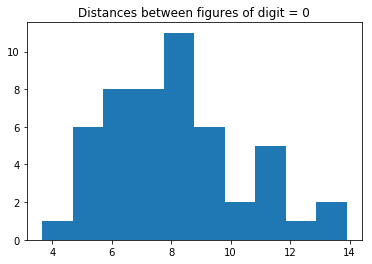

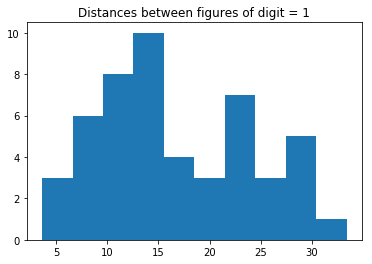

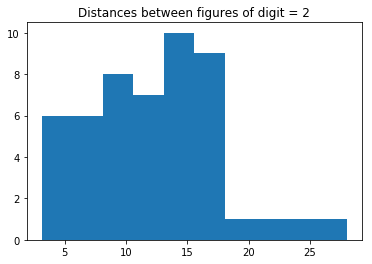

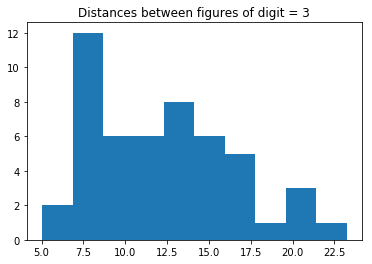

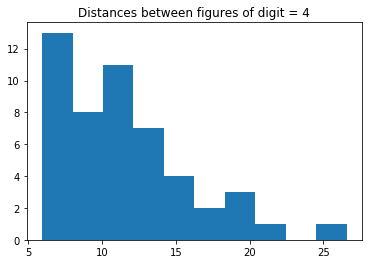

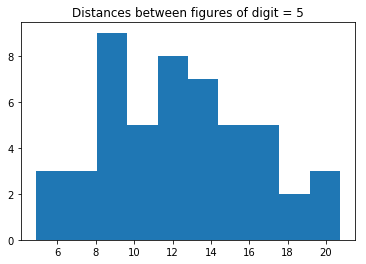

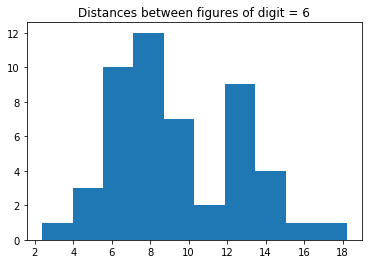

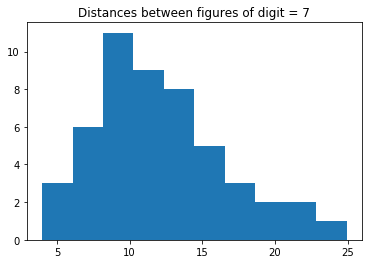

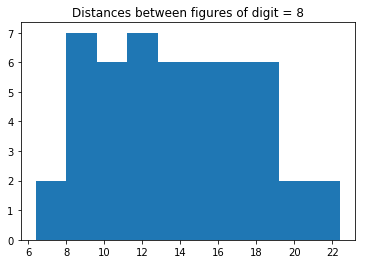

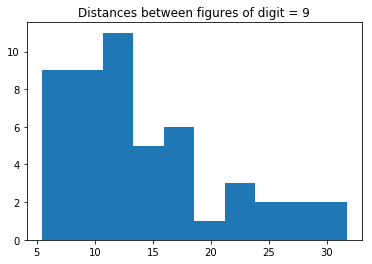

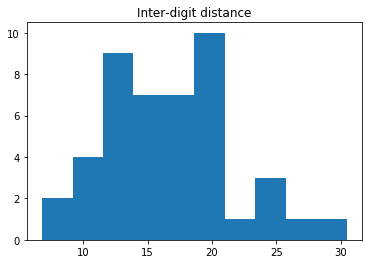

In [7]:
# get statistics about wasserstein distance between images in each category, and in different categories
digits = load_digits().data # digits are 8x8
target = load_digits().target # labels of each digit
for i in range(digits.shape[0]):
    digits[i] = digits[i] / digits[i].max()
dist_matrix = np.zeros((64, 64))
for i in range(64):
    for j in range(64):
        row1 = i // 8
        col1 = i % 8
        row2 = j // 8
        col2 = j % 8
        dist_matrix[i][j] = np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)

digit_samples = defaultdict(list)
for index, digit in enumerate(target):
    digit_samples[digit].append(digits[index]) 
digit_samples = {key : np.array(val) for key, val in digit_samples.items()}
    
for digit in range(10):
    # sample 20 digits from each digit class
    samples = digit_samples[digit]
    indices = set()
    while len(indices) < 50:
        index1 = np.random.randint(len(samples))
        index2 = np.random.randint(len(samples))
        if index1 != index2:
            indices.add((index1, index2))
    all_dist = []
    for index1, index2 in indices:
        dist, _, _, _ = wasserstein(samples[index1], samples[index2])
        all_dist.append(dist)
    fig, ax = plt.subplots()
    ax.set_title("Distances between figures of digit = {}".format(digit))
    _, bins, _ = ax.hist(all_dist)

all_dist = []
for digit1 in range(10):
    for digit2 in range(digit1):
        dist, _, _, _ = wasserstein(digit_samples[digit1][0], digit_samples[digit2][0])
        all_dist.append(dist)
fig, ax = plt.subplots()
ax.set_title("Inter-digit distance")
_, bins, _ = ax.hist(all_dist)
plt.show()

In [21]:
# compare Gaussian distribution between images to Wasserstein distance between images, and see if Wasserstein
# distance gives a stronger signal
same_image_normal = []
diff_image_normal = []
same_image_wasser = []
diff_image_wasser = []

for digit in range(10):
    print(digit)
    # sample 20 digits from each digit class to use as centers, and 100 others to compute distance from
    samples = digit_samples[digit]
    images = samples[np.random.choice(np.arange(len(samples)), size = 20 + 100)]
    other_images = np.concatenate([digit_samples[i][np.random.choice(np.arange(len(digit_samples[i])), size = 11)]
                                   for i in range(10) if i != digit])
    same_normal, diff_normal, same_wasser, diff_wasser = 0, 0, 0, 0
    for center in images[:20]:
        pdf_same = multivariate_normal.pdf(images[20:], center, sigma_x * np.identity(len(center)))
        dist_same = np.array([wasserstein(center, im)[0] for im in images[20:]])
        pdf_diff = multivariate_normal.pdf(other_images, center, sigma_x * np.identity(len(center)))
        dist_diff = np.array([wasserstein(center, im)[0] for im in other_images])
        
        same_normal += pdf_same.mean()
        same_wasser += dist_same.mean()
        diff_normal += pdf_diff.mean()
        diff_wasser += dist_diff.mean()
        
    same_image_normal.append(same_normal / 20)
    diff_image_normal.append(diff_normal / 20)
    same_image_wasser.append(same_wasser / 20)
    diff_image_wasser.append(diff_wasser / 20)

same_image_normal, diff_image_normal, same_image_wasser, diff_image_wasser = \
np.array(same_image_normal), np.array(diff_image_normal), np.array(same_image_wasser), np.array(diff_image_wasser)

0
1
2
3
4
5
6
7
8
9


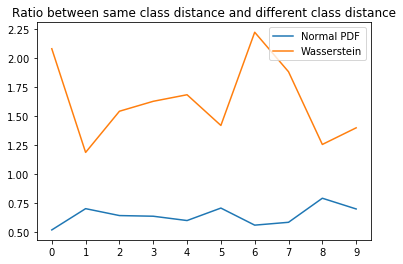

In [27]:
plt.title("Ratio between same class distance and different class distance")
plt.plot(range(10), diff_image_normal / same_image_normal, label = "Normal PDF")
plt.plot(range(10), diff_image_wasser / same_image_wasser, label = "Wasserstein")
plt.savefig("ratio_class_dist.png")
plt.xticks(range(10))
plt.legend()
plt.show()

In [34]:
def ABC_Gibbs(X, Z, epsilon = 50):
    # right now we use the collapsed Gibbs sampler
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    Z_new = Z.copy()
    for _ in range(10):
        for i in range(N):
            Z_sample, _, _ = sample_row(X, Z_new, i)
            Z_row = Z_sample[i]
            sample = generate_sample(Z_row, D)
            wasserstein_dist, _, _, _ = wasserstein(sample, X[i])
            print(wasserstein_dist)
            if wasserstein_dist < epsilon:
                Z_new = Z_sample
                print("Shape of new feature matrix: {}".format(Z_new.shape))
                break

In [26]:
vis_Z = []
def ABC_MCMC(X, Z, epsilon = 10):
    # right now we use the collapsed Gibbs sampler
    N = Z.shape[0]
    K = Z.shape[1]
    D = X.shape[1]
    Z_new = Z.copy()
    
    iterations = 5
    for it in range(iterations):
        print("iteration: ",it)
        for i in range(N):
            print(i)
            K = Z_new.shape[1]
            for j in range(K):
                Z_sample = Z_new.copy()
                Z_sample[i][j] = (Z_sample[i][j] + 1) % 2
                Z_row = Z_sample[i]
                A = np.random.multivariate_normal(np.zeros(K), sigma_a * np.identity(K), size = D).T
                sample = Z_row @ A
                wasserstein_dist, _, _, _ = wasserstein(sample, X[i])
                #print(wasserstein_dist)
                if wasserstein_dist < epsilon:
                    Z_new = Z_sample
                    vis_Z = Z_new.copy()
            Z_new_ph = Z_new.copy()
            for q in range(1,5):
                Z_sample = Z_new_ph.copy()
                Z_row = Z_sample[i]
                Z_row = np.append(Z_row, [1] * q)
                A = np.random.multivariate_normal(np.zeros(K+q), sigma_a * np.identity(K+q), size = D).T
                sample = Z_row @ A
                wasserstein_dist, _, _, _ = wasserstein(sample, X[i])
                #print(wasserstein_dist)
                if wasserstein_dist < epsilon:
                    Z_new = add_col_to_Z(Z_new, i, q)
                    vis_Z = Z_new.copy()
                else:
                    break

In [28]:
start = time()
test_data = select_digit_subset(digits, target)
data_count = test_data.shape[0]
feature_count = 15
Z = np.random.binomial(1, 0.25, [data_count, feature_count])
ABC_MCMC(test_data, Z)
print("Total Time: {}".format(time() - start))

iteration:  0
0
1
2
3
4
5
6


/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: overflow encountered in true_divide
/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide


7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
iteration:  1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104


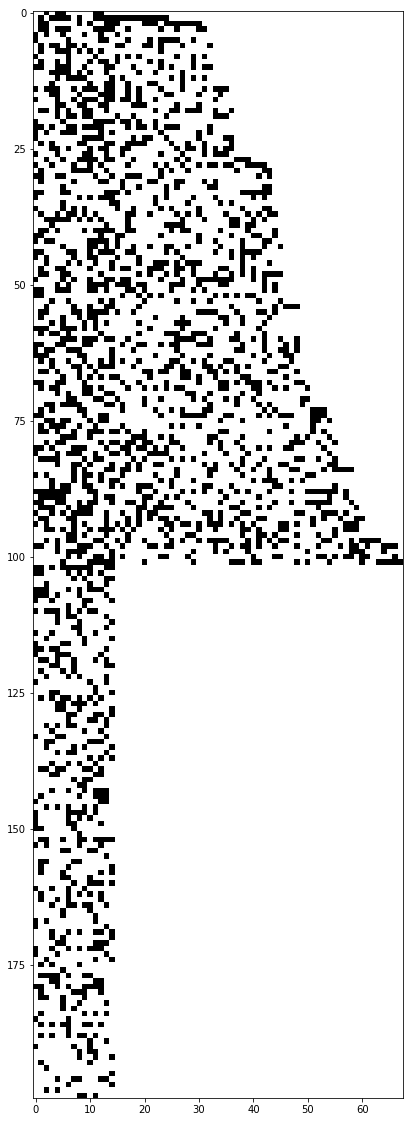

In [36]:
plt.figure(figsize = (10, 20))
plt.imshow(vis_Z, cmap='Greys', interpolation='none')
plt.show()

In [20]:
%load_ext line_profiler

In [25]:
%lprun -f ABC_MCMC ABC_MCMC(test_data, Z)

iteration:  0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide
/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in true_divide


21
22
23
24
25
26
27
28
29
30


/home/alexander/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: overflow encountered in true_divide


31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
